# 02 - Analysis: Random Forest Classification

Train Random Forest classifiers on all three labeling methods and compare performance.

**Goal:** Build wetland classifiers and evaluate which heuristic performs better.

**Inputs:**
- `data/processed/embeddings_with_wetland_labels_proportion.npz`
- `data/processed/embeddings_with_wetland_labels_hotspot.npz`
- `data/processed/embeddings_with_wetland_labels_intersection.npz`

**Outputs:**
- Trained models: `models/rf_wetland_*.pkl`
- Metrics: `results/metrics_*.json`

## Setup

In [71]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: wetland_prediction


## 1. Load Datasets

In [72]:
# Load proportion-based dataset
prop_path = Path('../data/processed/embeddings_with_wetland_labels_proportion.npz')
print(f'Loading: {prop_path}')
prop_data = np.load(prop_path, allow_pickle=True)

X_prop = prop_data['embeddings']
y_prop = prop_data['labels']
prop_ids = prop_data['sampling_event_ids']

print(f'\n✓ Proportion-based dataset:')
print(f'  Samples: {len(X_prop):,}')
print(f'  Features: {X_prop.shape[1]}')
print(f'  Wetland: {(y_prop == "wetland").sum():,} ({(y_prop == "wetland").sum() / len(y_prop) * 100:.1f}%)')
print(f'  Non-wetland: {(y_prop == "non-wetland").sum():,} ({(y_prop == "non-wetland").sum() / len(y_prop) * 100:.1f}%)')

Loading: ..\data\processed\embeddings_with_wetland_labels_proportion.npz

✓ Proportion-based dataset:
  Samples: 29,991
  Features: 16
  Wetland: 15,010 (50.0%)
  Non-wetland: 14,981 (50.0%)


In [73]:
# Load hotspot-based dataset
hot_path = Path('../data/processed/embeddings_with_wetland_labels_hotspot.npz')
print(f'Loading: {hot_path}')
hot_data = np.load(hot_path, allow_pickle=True)

X_hot = hot_data['embeddings']
y_hot = hot_data['labels']
hot_ids = hot_data['sampling_event_ids']

print(f'\n✓ Hotspot-based dataset:')
print(f'  Samples: {len(X_hot):,}')
print(f'  Features: {X_hot.shape[1]}')
print(f'  Wetland: {(y_hot == "wetland").sum():,} ({(y_hot == "wetland").sum() / len(y_hot) * 100:.1f}%)')
print(f'  Non-wetland: {(y_hot == "non-wetland").sum():,} ({(y_hot == "non-wetland").sum() / len(y_hot) * 100:.1f}%)')

# Load intersection dataset
int_path = Path('../data/processed/embeddings_with_wetland_labels_intersection.npz')
print(f'\nLoading: {int_path}')
int_data = np.load(int_path, allow_pickle=True)

X_int = int_data['embeddings']
y_int = int_data['labels']
int_ids = int_data['sampling_event_ids']

print(f'\n✓ Intersection dataset:')
print(f'  Samples: {len(X_int):,}')
print(f'  Features: {X_int.shape[1]}')
print(f'  Wetland: {(y_int == "wetland").sum():,} ({(y_int == "wetland").sum() / len(y_int) * 100:.1f}%)')
print(f'  Non-wetland: {(y_int == "non-wetland").sum():,} ({(y_int == "non-wetland").sum() / len(y_int) * 100:.1f}%)')

Loading: ..\data\processed\embeddings_with_wetland_labels_hotspot.npz

✓ Hotspot-based dataset:
  Samples: 3,760
  Features: 16
  Wetland: 1,314 (34.9%)
  Non-wetland: 2,446 (65.1%)

Loading: ..\data\processed\embeddings_with_wetland_labels_intersection.npz

✓ Intersection dataset:
  Samples: 1,165
  Features: 16
  Wetland: 574 (49.3%)
  Non-wetland: 591 (50.7%)


## 2. Train-Test Split

In [74]:
# Split proportion dataset
X_train_prop, X_test_prop, y_train_prop, y_test_prop = train_test_split(
    X_prop, y_prop, test_size=0.2, random_state=42, stratify=y_prop
)

print('Proportion-based split:')
print(f'  Train: {len(X_train_prop):,} samples')
print(f'  Test:  {len(X_test_prop):,} samples')
print(f'  Train wetland ratio: {(y_train_prop == "wetland").sum() / len(y_train_prop) * 100:.1f}%')
print(f'  Test wetland ratio:  {(y_test_prop == "wetland").sum() / len(y_test_prop) * 100:.1f}%')

Proportion-based split:
  Train: 23,992 samples
  Test:  5,999 samples
  Train wetland ratio: 50.1%
  Test wetland ratio:  50.0%


In [75]:
# Split hotspot dataset
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(
    X_hot, y_hot, test_size=0.2, random_state=42, stratify=y_hot
)

print('Hotspot-based split:')
print(f'  Train: {len(X_train_hot):,} samples')
print(f'  Test:  {len(X_test_hot):,} samples')
print(f'  Train wetland ratio: {(y_train_hot == "wetland").sum() / len(y_train_hot) * 100:.1f}%')
print(f'  Test wetland ratio:  {(y_test_hot == "wetland").sum() / len(y_test_hot) * 100:.1f}%')

# Split intersection dataset
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_int, y_int, test_size=0.2, random_state=42, stratify=y_int
)

print('\nIntersection split:')
print(f'  Train: {len(X_train_int):,} samples')
print(f'  Test:  {len(X_test_int):,} samples')
print(f'  Train wetland ratio: {(y_train_int == "wetland").sum() / len(y_train_int) * 100:.1f}%')
print(f'  Test wetland ratio:  {(y_test_int == "wetland").sum() / len(y_test_int) * 100:.1f}%')

Hotspot-based split:
  Train: 3,008 samples
  Test:  752 samples
  Train wetland ratio: 34.9%
  Test wetland ratio:  35.0%

Intersection split:
  Train: 932 samples
  Test:  233 samples
  Train wetland ratio: 49.2%
  Test wetland ratio:  49.4%


## 3. Train Random Forest - Proportion-based

In [76]:
print('Training Random Forest on proportion-based labels...')

rf_prop = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_prop.fit(X_train_prop, y_train_prop)

print('\n✓ Training complete!')

Training Random Forest on proportion-based labels...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s



✓ Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


## 4. Evaluate - Proportion-based

In [77]:
# Predictions
y_pred_prop = rf_prop.predict(X_test_prop)
y_proba_prop = rf_prop.predict_proba(X_test_prop)[:, 1]  # Probability of wetland

# Metrics
acc_prop = accuracy_score(y_test_prop, y_pred_prop)
prec_prop = precision_score(y_test_prop, y_pred_prop, pos_label='wetland')
rec_prop = recall_score(y_test_prop, y_pred_prop, pos_label='wetland')
f1_prop = f1_score(y_test_prop, y_pred_prop, pos_label='wetland')
auc_prop = roc_auc_score((y_test_prop == 'wetland').astype(int), y_proba_prop)

print('='*60)
print('PROPORTION-BASED MODEL PERFORMANCE')
print('='*60)
print(f'Accuracy:  {acc_prop:.4f}')
print(f'Precision: {prec_prop:.4f}')
print(f'Recall:    {rec_prop:.4f}')
print(f'F1 Score:  {f1_prop:.4f}')
print(f'ROC AUC:   {auc_prop:.4f}')
print('='*60)

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_prop, y_pred_prop))

PROPORTION-BASED MODEL PERFORMANCE
Accuracy:  0.9462
Precision: 0.9320
Recall:    0.9627
F1 Score:  0.9471
ROC AUC:   0.9894

Classification Report:
              precision    recall  f1-score   support

 non-wetland       0.96      0.93      0.95      2997
     wetland       0.93      0.96      0.95      3002

    accuracy                           0.95      5999
   macro avg       0.95      0.95      0.95      5999
weighted avg       0.95      0.95      0.95      5999



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


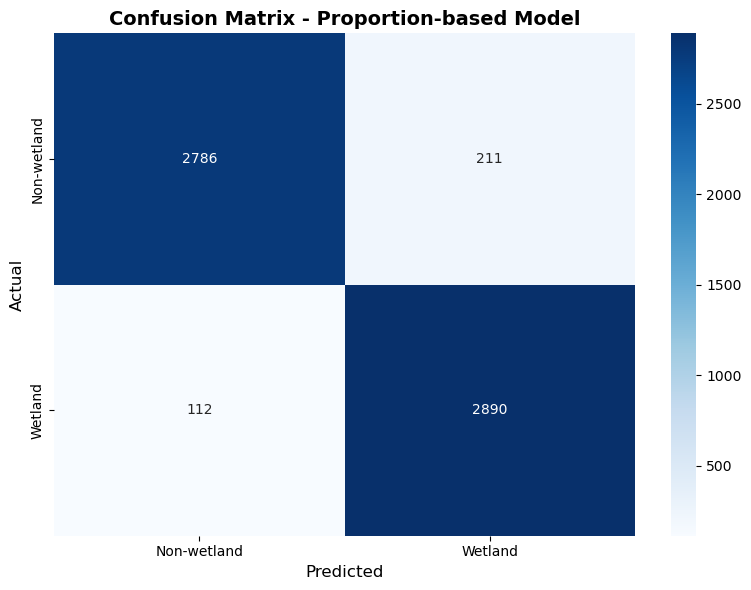

In [78]:
# Confusion matrix
cm_prop = confusion_matrix(y_test_prop, y_pred_prop, labels=['non-wetland', 'wetland'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_prop, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-wetland', 'Wetland'],
            yticklabels=['Non-wetland', 'Wetland'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Proportion-based Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

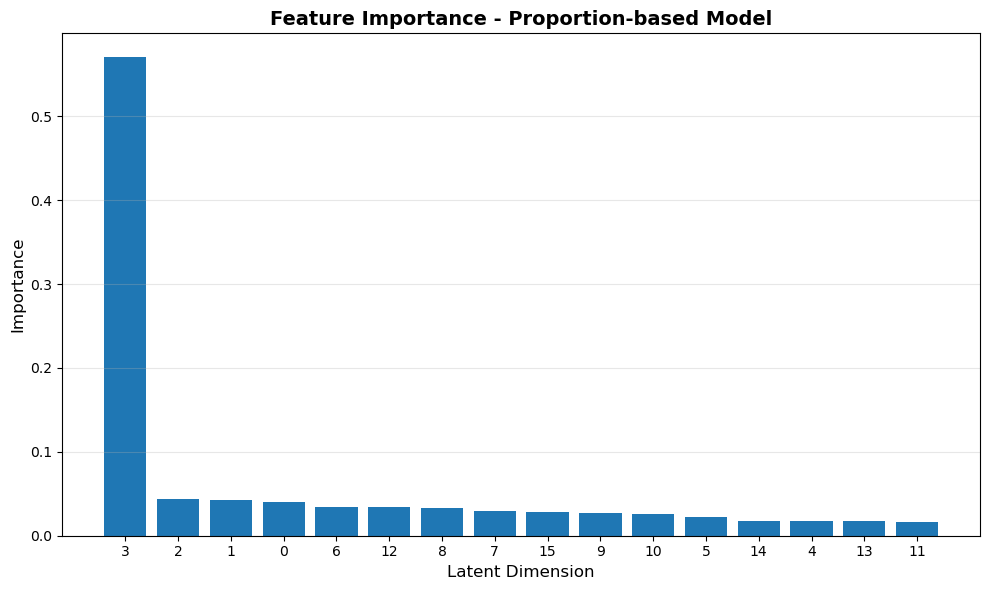

Top 5 most important features:
  Latent dim 3: 0.5703
  Latent dim 2: 0.0443
  Latent dim 1: 0.0426
  Latent dim 0: 0.0398
  Latent dim 6: 0.0348


In [79]:
# Feature importance
importances_prop = rf_prop.feature_importances_
indices_prop = np.argsort(importances_prop)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_prop)), importances_prop[indices_prop])
plt.xlabel('Latent Dimension', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance - Proportion-based Model', fontsize=14, fontweight='bold')
plt.xticks(range(len(importances_prop)), indices_prop)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('Top 5 most important features:')
for i in range(min(5, len(importances_prop))):
    print(f'  Latent dim {indices_prop[i]}: {importances_prop[indices_prop[i]]:.4f}')

## 5. Train Random Forest - Hotspot-based

In [80]:
print('Training Random Forest on hotspot-based labels...')

rf_hot = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_hot.fit(X_train_hot, y_train_hot)

print('\n✓ Training complete!')

Training Random Forest on hotspot-based labels...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished



✓ Training complete!


## 6. Evaluate - Hotspot-based

In [81]:
# Predictions
y_pred_hot = rf_hot.predict(X_test_hot)
y_proba_hot = rf_hot.predict_proba(X_test_hot)[:, 1]  # Probability of wetland

# Metrics
acc_hot = accuracy_score(y_test_hot, y_pred_hot)
prec_hot = precision_score(y_test_hot, y_pred_hot, pos_label='wetland')
rec_hot = recall_score(y_test_hot, y_pred_hot, pos_label='wetland')
f1_hot = f1_score(y_test_hot, y_pred_hot, pos_label='wetland')
auc_hot = roc_auc_score((y_test_hot == 'wetland').astype(int), y_proba_hot)

print('='*60)
print('HOTSPOT-BASED MODEL PERFORMANCE')
print('='*60)
print(f'Accuracy:  {acc_hot:.4f}')
print(f'Precision: {prec_hot:.4f}')
print(f'Recall:    {rec_hot:.4f}')
print(f'F1 Score:  {f1_hot:.4f}')
print(f'ROC AUC:   {auc_hot:.4f}')
print('='*60)

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_hot, y_pred_hot))

HOTSPOT-BASED MODEL PERFORMANCE
Accuracy:  0.8790
Precision: 0.8496
Recall:    0.7947
F1 Score:  0.8212
ROC AUC:   0.9420

Classification Report:
              precision    recall  f1-score   support

 non-wetland       0.89      0.92      0.91       489
     wetland       0.85      0.79      0.82       263

    accuracy                           0.88       752
   macro avg       0.87      0.86      0.86       752
weighted avg       0.88      0.88      0.88       752



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


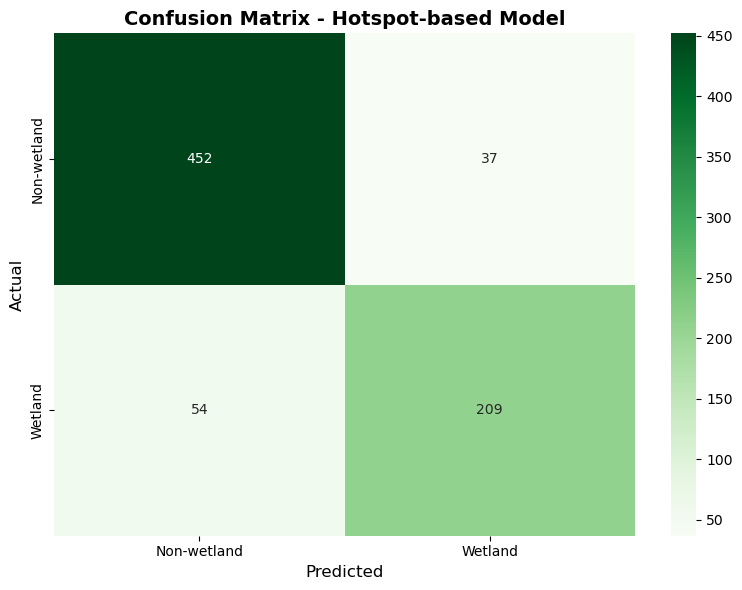

In [82]:
# Confusion matrix
cm_hot = confusion_matrix(y_test_hot, y_pred_hot, labels=['non-wetland', 'wetland'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hot, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Non-wetland', 'Wetland'],
            yticklabels=['Non-wetland', 'Wetland'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Hotspot-based Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

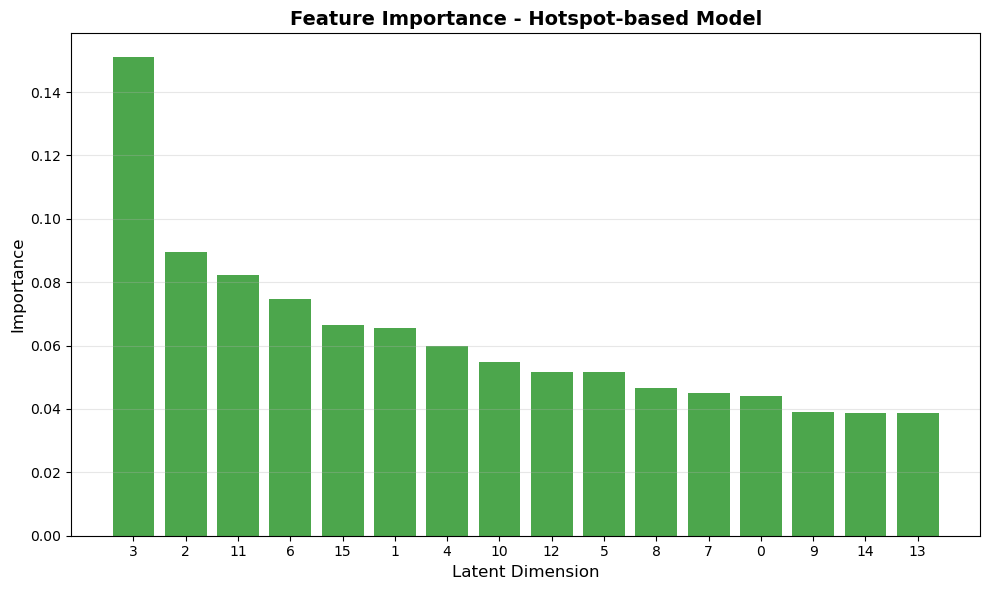

Top 5 most important features:
  Latent dim 3: 0.1510
  Latent dim 2: 0.0895
  Latent dim 11: 0.0822
  Latent dim 6: 0.0747
  Latent dim 15: 0.0666


In [83]:
# Feature importance
importances_hot = rf_hot.feature_importances_
indices_hot = np.argsort(importances_hot)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_hot)), importances_hot[indices_hot], color='green', alpha=0.7)
plt.xlabel('Latent Dimension', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance - Hotspot-based Model', fontsize=14, fontweight='bold')
plt.xticks(range(len(importances_hot)), indices_hot)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('Top 5 most important features:')
for i in range(min(5, len(importances_hot))):
    print(f'  Latent dim {indices_hot[i]}: {importances_hot[indices_hot[i]]:.4f}')

## 7. Train Random Forest - Intersection

In [84]:
print('Training Random Forest on intersection labels...')

rf_int = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_int.fit(X_train_int, y_train_int)

print('\n✓ Training complete!')

Training Random Forest on intersection labels...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished



✓ Training complete!


## 8. Evaluate - Intersection

In [85]:
# Predictions
y_pred_int = rf_int.predict(X_test_int)
y_proba_int = rf_int.predict_proba(X_test_int)[:, 1]  # Probability of wetland

# Metrics
acc_int = accuracy_score(y_test_int, y_pred_int)
prec_int = precision_score(y_test_int, y_pred_int, pos_label='wetland')
rec_int = recall_score(y_test_int, y_pred_int, pos_label='wetland')
f1_int = f1_score(y_test_int, y_pred_int, pos_label='wetland')
auc_int = roc_auc_score((y_test_int == 'wetland').astype(int), y_proba_int)

print('='*60)
print('INTERSECTION MODEL PERFORMANCE')
print('='*60)
print(f'Accuracy:  {acc_int:.4f}')
print(f'Precision: {prec_int:.4f}')
print(f'Recall:    {rec_int:.4f}')
print(f'F1 Score:  {f1_int:.4f}')
print(f'ROC AUC:   {auc_int:.4f}')
print('='*60)

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_int, y_pred_int))

INTERSECTION MODEL PERFORMANCE
Accuracy:  0.9700
Precision: 0.9821
Recall:    0.9565
F1 Score:  0.9692
ROC AUC:   0.9968

Classification Report:
              precision    recall  f1-score   support

 non-wetland       0.96      0.98      0.97       118
     wetland       0.98      0.96      0.97       115

    accuracy                           0.97       233
   macro avg       0.97      0.97      0.97       233
weighted avg       0.97      0.97      0.97       233



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


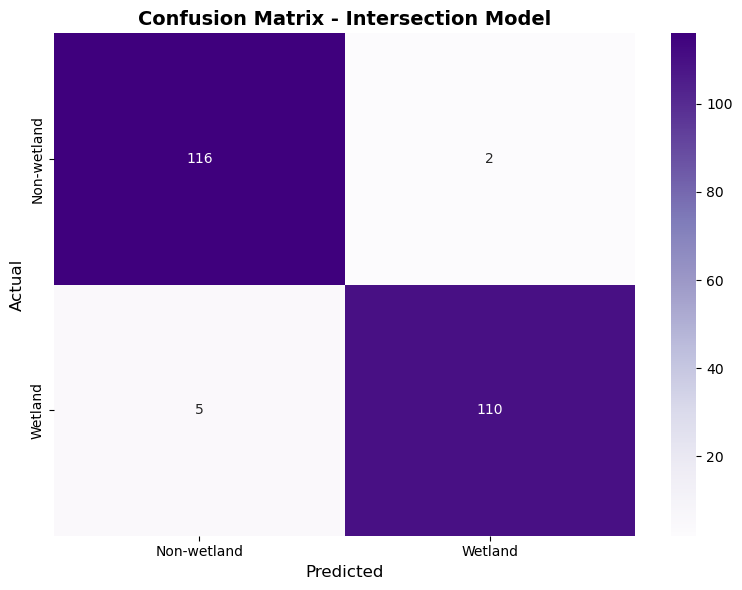

In [86]:
# Confusion matrix
cm_int = confusion_matrix(y_test_int, y_pred_int, labels=['non-wetland', 'wetland'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_int, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Non-wetland', 'Wetland'],
            yticklabels=['Non-wetland', 'Wetland'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Intersection Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

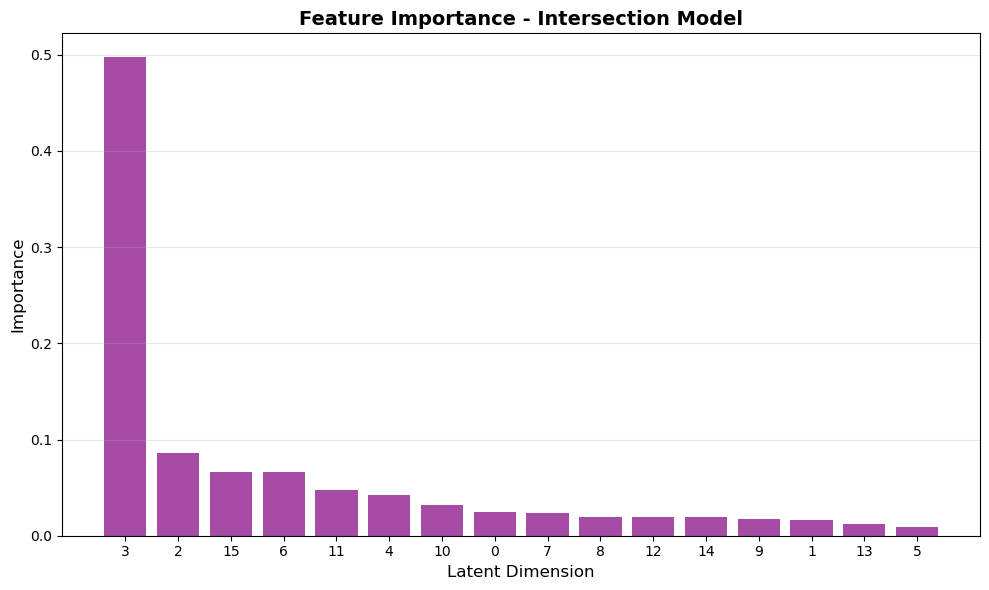

Top 5 most important features:
  Latent dim 3: 0.4974
  Latent dim 2: 0.0862
  Latent dim 15: 0.0665
  Latent dim 6: 0.0661
  Latent dim 11: 0.0475


In [87]:
# Feature importance
importances_int = rf_int.feature_importances_
indices_int = np.argsort(importances_int)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_int)), importances_int[indices_int], color='purple', alpha=0.7)
plt.xlabel('Latent Dimension', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance - Intersection Model', fontsize=14, fontweight='bold')
plt.xticks(range(len(importances_int)), indices_int)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('Top 5 most important features:')
for i in range(min(5, len(importances_int))):
    print(f'  Latent dim {indices_int[i]}: {importances_int[indices_int[i]]:.4f}')

## 9. Compare Models

In [88]:
# Comparison table
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Proportion-based': [acc_prop, prec_prop, rec_prop, f1_prop, auc_prop],
    'Hotspot-based': [acc_hot, prec_hot, rec_hot, f1_hot, auc_hot],
    'Intersection': [acc_int, prec_int, rec_int, f1_int, auc_int]
}).round(4)

print('='*90)
print('MODEL COMPARISON')
print('='*90)
print(comparison.to_string(index=False))
print('='*90)

MODEL COMPARISON
   Metric  Proportion-based  Hotspot-based  Intersection
 Accuracy            0.9462         0.8790        0.9700
Precision            0.9320         0.8496        0.9821
   Recall            0.9627         0.7947        0.9565
 F1 Score            0.9471         0.8212        0.9692
  ROC AUC            0.9894         0.9420        0.9968


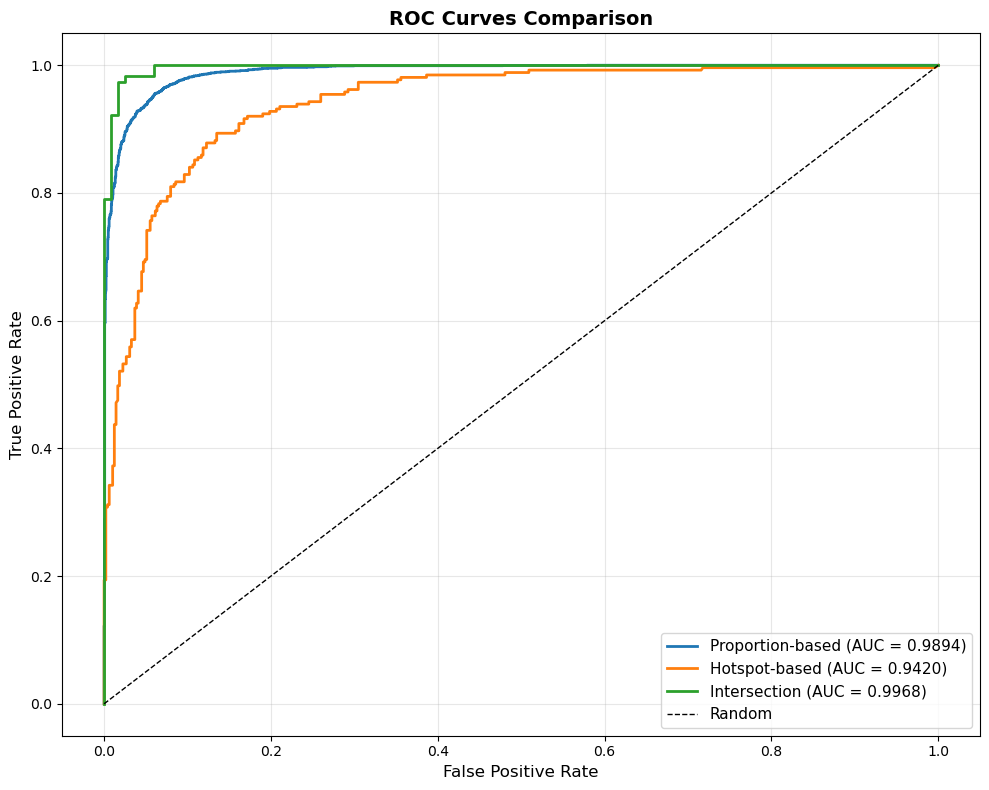

In [89]:
# ROC curves comparison
fpr_prop, tpr_prop, _ = roc_curve((y_test_prop == 'wetland').astype(int), y_proba_prop)
fpr_hot, tpr_hot, _ = roc_curve((y_test_hot == 'wetland').astype(int), y_proba_hot)
fpr_int, tpr_int, _ = roc_curve((y_test_int == 'wetland').astype(int), y_proba_int)

plt.figure(figsize=(10, 8))
plt.plot(fpr_prop, tpr_prop, label=f'Proportion-based (AUC = {auc_prop:.4f})', linewidth=2)
plt.plot(fpr_hot, tpr_hot, label=f'Hotspot-based (AUC = {auc_hot:.4f})', linewidth=2)
plt.plot(fpr_int, tpr_int, label=f'Intersection (AUC = {auc_int:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

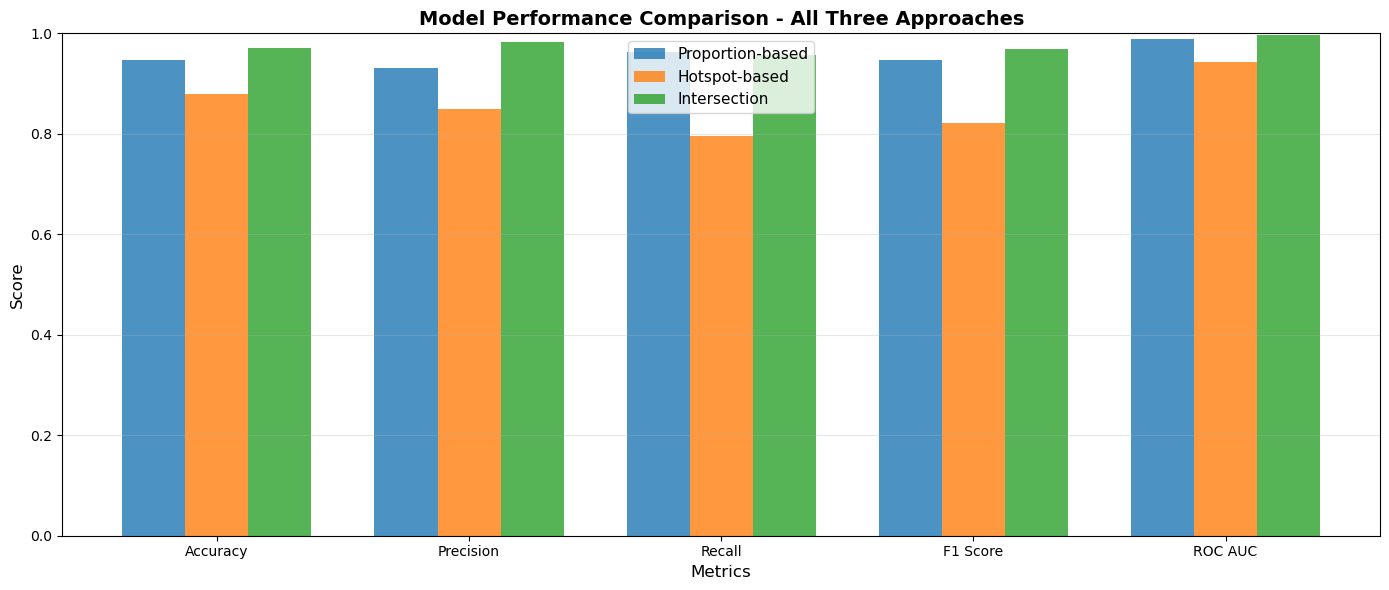

In [90]:
# Metrics bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
prop_scores = [acc_prop, prec_prop, rec_prop, f1_prop, auc_prop]
hot_scores = [acc_hot, prec_hot, rec_hot, f1_hot, auc_hot]
int_scores = [acc_int, prec_int, rec_int, f1_int, auc_int]

x = np.arange(len(metrics_names))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, prop_scores, width, label='Proportion-based', alpha=0.8)
ax.bar(x, hot_scores, width, label='Hotspot-based', alpha=0.8)
ax.bar(x + width, int_scores, width, label='Intersection', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison - All Three Approaches', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 10. Save Models and Results

In [91]:
# Create output directories
models_dir = Path('../models')
results_dir = Path('../results')
models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

print('Created output directories')

Created output directories


In [92]:
# Save proportion-based model
prop_model_path = models_dir / 'rf_wetland_proportion.pkl'
with open(prop_model_path, 'wb') as f:
    pickle.dump(rf_prop, f)

print(f'✓ Saved proportion-based model: {prop_model_path}')
print(f'  File size: {prop_model_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved proportion-based model: ..\models\rf_wetland_proportion.pkl
  File size: 13.89 MB


In [93]:
# Save hotspot-based model
hot_model_path = models_dir / 'rf_wetland_hotspot.pkl'
with open(hot_model_path, 'wb') as f:
    pickle.dump(rf_hot, f)

print(f'✓ Saved hotspot-based model: {hot_model_path}')
print(f'  File size: {hot_model_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved hotspot-based model: ..\models\rf_wetland_hotspot.pkl
  File size: 3.72 MB


In [94]:
# Save proportion-based metrics
prop_metrics = {
    'model_type': 'RandomForest',
    'labeling_method': 'proportion_heuristic',
    'n_samples_train': len(X_train_prop),
    'n_samples_test': len(X_test_prop),
    'n_features': X_train_prop.shape[1],
    'accuracy': float(acc_prop),
    'precision': float(prec_prop),
    'recall': float(rec_prop),
    'f1_score': float(f1_prop),
    'roc_auc': float(auc_prop),
    'confusion_matrix': cm_prop.tolist(),
    'feature_importances': importances_prop.tolist()
}

prop_metrics_path = results_dir / 'metrics_proportion.json'
with open(prop_metrics_path, 'w') as f:
    json.dump(prop_metrics, f, indent=2)

print(f'✓ Saved proportion-based metrics: {prop_metrics_path}')

✓ Saved proportion-based metrics: ..\results\metrics_proportion.json


In [95]:
# Save proportion-based test results
prop_results_path = Path('../results/bird_proportion_test_results.npz')
np.savez(
    prop_results_path,
    y_true=y_test_prop,
    y_pred=y_pred_prop,
    y_proba=y_proba_prop
)
print(f'✓ Saved proportion-based test results: {prop_results_path}')

✓ Saved proportion-based test results: ..\results\bird_proportion_test_results.npz


In [96]:
# Save hotspot-based metrics
hot_metrics = {
    'model_type': 'RandomForest',
    'labeling_method': 'hotspot_name_heuristic',
    'n_samples_train': len(X_train_hot),
    'n_samples_test': len(X_test_hot),
    'n_features': X_train_hot.shape[1],
    'accuracy': float(acc_hot),
    'precision': float(prec_hot),
    'recall': float(rec_hot),
    'f1_score': float(f1_hot),
    'roc_auc': float(auc_hot),
    'confusion_matrix': cm_hot.tolist(),
    'feature_importances': importances_hot.tolist()
}

hot_metrics_path = results_dir / 'metrics_hotspot.json'
with open(hot_metrics_path, 'w') as f:
    json.dump(hot_metrics, f, indent=2)

print(f'✓ Saved hotspot-based metrics: {hot_metrics_path}')

# Save intersection model
int_model_path = models_dir / 'rf_wetland_intersection.pkl'
with open(int_model_path, 'wb') as f:
    pickle.dump(rf_int, f)
print(f'✓ Saved intersection model: {int_model_path}')

# Save intersection metrics
int_metrics = {
    'model_type': 'RandomForest',
    'labeling_method': 'intersection_heuristic',
    'n_samples_train': len(X_train_int),
    'n_samples_test': len(X_test_int),
    'n_features': X_train_int.shape[1],
    'accuracy': float(acc_int),
    'precision': float(prec_int),
    'recall': float(rec_int),
    'f1_score': float(f1_int),
    'roc_auc': float(auc_int),
    'confusion_matrix': cm_int.tolist(),
    'feature_importances': importances_int.tolist()
}

int_metrics_path = results_dir / 'metrics_intersection.json'
with open(int_metrics_path, 'w') as f:
    json.dump(int_metrics, f, indent=2)
print(f'✓ Saved intersection metrics: {int_metrics_path}')

# Save intersection test results
int_results_path = results_dir / 'intersection_test_results.npz'
np.savez(
    int_results_path,
    y_true=y_test_int,
    y_pred=y_pred_int,
    y_proba=y_proba_int
)
print(f'✓ Saved intersection test results: {int_results_path}')

✓ Saved hotspot-based metrics: ..\results\metrics_hotspot.json
✓ Saved intersection model: ..\models\rf_wetland_intersection.pkl
✓ Saved intersection metrics: ..\results\metrics_intersection.json
✓ Saved intersection test results: ..\results\intersection_test_results.npz


In [97]:
# Save hotspot-based test results
hot_results_path = Path('../results/hotspot_name_test_results.npz')
np.savez(
    hot_results_path,
    y_true=y_test_hot,
    y_pred=y_pred_hot,
    y_proba=y_proba_hot
)
print(f'✓ Saved hotspot-based test results: {hot_results_path}')

✓ Saved hotspot-based test results: ..\results\hotspot_name_test_results.npz


## Summary

In [98]:
print('='*70)
print('ANALYSIS COMPLETE')
print('='*70)
print(f'\n📊 Trained 3 Random Forest models:')
print(f'\n1. PROPORTION-BASED MODEL')
print(f'   Accuracy:  {acc_prop:.4f}')
print(f'   F1 Score:  {f1_prop:.4f}')
print(f'   ROC AUC:   {auc_prop:.4f}')
print(f'   Saved:     {prop_model_path.name}')
print(f'\n2. HOTSPOT-BASED MODEL')
print(f'   Accuracy:  {acc_hot:.4f}')
print(f'   F1 Score:  {f1_hot:.4f}')
print(f'   ROC AUC:   {auc_hot:.4f}')
print(f'   Saved:     {hot_model_path.name}')
print(f'\n3. INTERSECTION MODEL')
print(f'   Accuracy:  {acc_int:.4f}')
print(f'   F1 Score:  {f1_int:.4f}')
print(f'   ROC AUC:   {auc_int:.4f}')
print(f'   Saved:     {int_model_path.name}')
print(f'\n📁 Saved outputs:')
print(f'   Models:  {models_dir}/')
print(f'   Metrics: {results_dir}/')
print(f'\n✨ Analysis complete!')
print('='*70)

ANALYSIS COMPLETE

📊 Trained 3 Random Forest models:

1. PROPORTION-BASED MODEL
   Accuracy:  0.9462
   F1 Score:  0.9471
   ROC AUC:   0.9894
   Saved:     rf_wetland_proportion.pkl

2. HOTSPOT-BASED MODEL
   Accuracy:  0.8790
   F1 Score:  0.8212
   ROC AUC:   0.9420
   Saved:     rf_wetland_hotspot.pkl

3. INTERSECTION MODEL
   Accuracy:  0.9700
   F1 Score:  0.9692
   ROC AUC:   0.9968
   Saved:     rf_wetland_intersection.pkl

📁 Saved outputs:
   Models:  ..\models/
   Metrics: ..\results/

✨ Analysis complete!
